In [2]:
# Selina 26 Feb 2019
# Program to create a logistic regression model to predict readmission rates
# Import relevant modules
import os
import numpy as np
#from sklearn import datasets, linear_model
#from sklearn.metrics import mean_squared_error, r2_score

# Set directories, filenames and url api
dataFolder = os.getcwd()
inputFileName='10kDiabetes.csv'
    # This is my filename with merged data and geodata
input_file=os.path.join(dataFolder,inputFileName)

# Read in data
raw_data=pd.read_csv(input_file)
#raw_data.columns  Have a look at what the columns are and see the unique info
#raw_data.loc[:,'readmitted'].unique()


In [3]:
# Ok, first apply criteria for acceptance of data
# Apply the same criteria as the paper used

# First of all, we only want to look at inpatient encounters 
# with hospitaliztion that lasted 1-14 days
cleaned_data=raw_data.copy()

idx1=cleaned_data.index[cleaned_data['time_in_hospital']>0]
idx2=cleaned_data.index[cleaned_data['time_in_hospital']<=14]
idx=idx1 & idx2
cleaned_data=cleaned_data.loc[idx,:]

# Ok, for our analysis, remove patient data with multiple inpatient encounters
idx=cleaned_data.index[cleaned_data['number_inpatient']==0]
cleaned_data=cleaned_data.loc[idx,:]
#cleaned_data.columns

# Only look at data where patients have been diagnosed with diabetes
idx1=cleaned_data['diag_1_desc'].str.contains('diabetes mellitus',case=False)
idx2=cleaned_data['diag_2_desc'].str.contains('diabetes mellitus',case=False)
idx3=cleaned_data['diag_3_desc'].str.contains('diabetes mellitus',case=False)
idx=idx1 | idx2 | idx3
idx=idx[idx==True]

cleaned_data=cleaned_data.loc[idx.index,:]
#Series.str.contains(pat, case=True, flags=0, na=nan, regex=True)[source]

# Remove data where patient died or was transfered to hospice
idx1=cleaned_data['discharge_disposition_id'].str.contains('expired',case=False)
idx2=cleaned_data['discharge_disposition_id'].str.contains('hospice',case=False)
idx3=cleaned_data['discharge_disposition_id'].apply(pd.isnull)
idx=(idx1 | idx2)
idx=idx[idx==True]
cleaned_data=cleaned_data.drop(index=idx.index)
idx3=idx3[idx3==True]
cleaned_data.loc[idx3.index,'discharge_disposition_id']='NA'
# Also, regroup data into home and other (create new variable)
idx=cleaned_data['discharge_disposition_id'].str.contains('home',case=False)
idx1=idx[idx==True]
cleaned_data.loc[idx1.index,'discharge_home']=idx1
idx2=idx[idx!=True]
cleaned_data.loc[idx2.index,'discharge_home']=idx2
cleaned_data.loc[idx3.index,'discharge_home']='NA'


# In this dataset, medication was always given so no need to apply criterion
# (Checked in excel)


In [4]:
# Also, clean up data
idx=cleaned_data.index[cleaned_data['race']=='?']
cleaned_data.loc[idx,'race']='NA'

idx1=cleaned_data.index[cleaned_data['admission_type_id'].apply(pd.isnull)]
idx2=cleaned_data.index[cleaned_data['admission_type_id']=='Not Available']
idx3=cleaned_data.index[cleaned_data['admission_type_id']=='Not Mapped']
idx=idx1 | idx2 | idx3
cleaned_data.loc[idx,'admission_type_id']='NA'

# Note: Medical specialty had too many missing values in paper
idx=cleaned_data.index[cleaned_data['medical_specialty']=='?']
cleaned_data.loc[idx,'medical_specialty']='NA'

# We can drop payer code because it will not be relevant
cleaned_data=cleaned_data.drop(columns='payer_code')

In [97]:
# Ok..now let's do the logistic regression
# We will take a different approach from the paper, since the A1C measurement 
# is not the focus
# Our goal is to identify the risk of readmission, whatever the predictors could be
# So, first let's fit a saturated model

# # First let's get our predictors in the right format
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import sklearn.metrics


# Following is code for sklearn version
y=cleaned_data.loc[:,'readmitted'] 
# First deal with categorical variables
cat_variables=['race','gender','age','admission_type_id',\
                'max_glu_serum','A1Cresult','change','diabetesMed','discharge_home']

X=pd.DataFrame()
X = X.fillna(0) # with 0s rather than NaNs
for ii,var in enumerate(cat_variables):
    xdummy=pd.get_dummies(cleaned_data.loc[:,var],prefix=var)
    X=pd.concat([X,xdummy],axis=1)

# Now deal with quantitative varibles
quant_variables=['num_lab_procedures','num_procedures','num_medications','number_outpatient',\
                'number_emergency','time_in_hospital']

# Now add to our X
for ii,var in enumerate(quant_variables):
    xtemp=cleaned_data.loc[:,var]
    X=pd.concat([X,xtemp],axis=1)

    
# Now split our data into 3 groups:
# 1. Training set, validation set (to select best parameters of model), & testing set
# Split into 60:20:20
X_train, X_test_all, y_train, y_test_all = train_test_split(X, y, test_size=0.2)
    # We have training set
X_xtest, X_validate, y_xtest, y_validate = train_test_split(X_test_all, y_test_all, test_size=0.5)



In [98]:
## Ok..we saw from our data exploration that our sample is bias to not_readmitted
# This will affect the logistic regression model
# So, subsample the not_readmitted training and validating data
drop_n=sum(y_train==False)-sum(y_train==True) # Total # of samples you wanna drop
maxn=sum(y_train==True) # Total number of subsamples that you want
weights1=(y_train==False) # Only sample from not_readmitted data
weights2=(y_train==True) # Sample all of the readmitted data
xsub_train1=X_train.sample(n=maxn,weights=weights1,random_state=2) # Randomly subsampled data
xsub_train2=X_train.sample(n=maxn,weights=weights2)
Xsub_train=pd.concat([xsub_train1,xsub_train2],axis=0)
# Ok, we have subsampled, now shuffle back the data
Xsub_train=Xsub_train.sample(frac=1)
ysub_train=y_train.reindex(index=Xsub_train.index) #Subsample y
# Now do again from validation set
drop_n=sum(y_validate==False)-sum(y_validate==True) # Total # of samples you wanna drop
maxn=sum(y_validate==True) # Total number of subsamples that you want
weights1=(y_validate==False) # Only sample from not_readmitted data
weights2=(y_validate==True) # Sample all of the readmitted data
xsub_validate1=X_validate.sample(n=maxn,weights=weights1,random_state=2) # Randomly subsampled data
xsub_validate2=X_validate.sample(n=maxn,weights=weights2)
Xsub_validate=pd.concat([xsub_validate1,xsub_validate2],axis=0)
# Ok, we have subsampled, now shuffle back the data
Xsub_validateT=Xsub_validate.sample(frac=1)
ysub_validate=y_validate.reindex(index=Xsub_validate.index) #Subsample y

# Ok, put the training and validating data we did not use into the testing data
y_train=y_train.drop(index=Xsub_train.index)
X_train=X_train.drop(index=Xsub_train.index)
y_validate=y_validate.drop(index=Xsub_validate.index)
X_validate=X_validate.drop(index=Xsub_validate.index)
y_xtest=pd.concat([y_xtest,y_train],axis=0)
X_xtest=pd.concat([X_xtest,X_train],axis=0)

        

In [91]:
maxn

66

In [127]:
# Ok, let's fit the saturated model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold,GridSearchCV, RandomizedSearchCV

#LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None)
# Ok, let's search for the best parameters
penalty = ['l1','l2']
solver=['liblinear','saga']
C=[0.1,0.25,0.5,0.75,1,1.5,2,5,10,20,50,100]
kfoldsets = KFold(n_splits=10,shuffle=True)

params = [dict(penalty=penalty), dict(C=C)] # Put into dictionary format

logregCV = LogisticRegression(random_state=5,verbose=True,solver='liblinear')
grid = GridSearchCV(logregCV, param_grid=params, cv=kfoldsets)
#grid = RandomizedSearchCV(decisionTreeCV, param_distributions=params, cv=kfoldsets)
# Fit the grid
grid=grid.fit(Xsub_validate, ysub_validate)
# Return the optimal params
bestParams=grid.best_estimator_

# Now do actual fit
logreg = LogisticRegression(random_state=5,C=bestParams.C,solver=bestParams.solver,penalty=bestParams.penalty)
logreg.fit(Xsub_train,ysub_train)
# Now cross-validate (for generalization)
y_pred = logreg.predict(X_xtest)
# logreg_mse=mean_squared_error(y_pred,y_xtest)
# print('Decision Tree Regression R squared: %.4f' % decisionTree.score(X_xtest, y_xtest))
# print('Decision Tree Regression mse: %.4f' % dt_mse)
# print('Decision Tree Regression average deviation: %.4f' % math.sqrt(dt_mse))



[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model accuracy : 0.56
[[515 411]
 [ 16  38]]


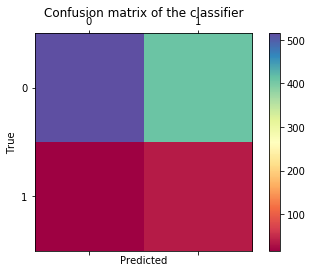

In [128]:
# Plot how well the model fit
from sklearn.metrics import confusion_matrix
#import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

logreg_accuracy=np.sum(y_pred==y_xtest)/y_xtest.shape[0]
print('Model accuracy : %.2f' %logreg_accuracy)
cmatrix=confusion_matrix(y_xtest,y_pred,labels=logreg.classes_)
cmatrix
# Show it as a heatmap
#ax=sns.heatmap(cmatrix, vmin=0, vmax=np.max(cmatrix))


# Plot the confusion matrix
labels = logreg.classes_
print(cmatrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cmatrix,cmap=cmap)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [135]:
logreg.

array([False,  True])

In [123]:
grid.best_estimator_


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=5, solver='warn',
          tol=0.0001, verbose=True, warm_start=False)